## Multi-Modal Embedder Fusion Architecture Comparison

In this notebook, we extend the analysis started with data visualization and preparation to conduct multimodal machine learning experiments focused on fusion strategies for combining multiple data modalities. Different modalities capture complementary information which, when fused, can lead to more robust and performant models.

We focus on two fusion strategies, whose architectural choices, advantages, and limitations are discussed in detail in the `Experiments` section:

- **Late Fusion**, where modalities are processed independently and combined at a later stage;  
- **Intermediate Fusion**, where intermediate representations from unimodal networks are combined via concatenation, addition, or multiplication.  

In our setting, the two modalities are RGB and LiDAR images, previously analyzed in notebook `01_dataset_exploration.ipynb`. The task is binary classification of object shape (cube vs. sphere). We implement both fusion strategies and, for intermediate fusion, its three variants, performing a structured design exploration to identify the best-performing architecture for this task and modality pair.

The first section defines the experiment configuration, including path setup and initialization of the relevant data loaders.

In [138]:
%load_ext autoreload
%autoreload 2

import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import json 
import torch
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

import pandas as pd

from handsoncv.datasets import CILPFusionDataset
from handsoncv.models import LateFusionNet, IntermediateFusionNet
from handsoncv.training import train_fusion_cilp_model
from handsoncv.utils import set_seed, seed_worker
from handsoncv.visualization import plot_table_task3_metrics
from torchvision import transforms
from torch.utils.data import DataLoader

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")
RESULTS_DIR = os.path.join(ROOT_PATH, "results", "tables")
os.makedirs(RESULTS_DIR, exist_ok=True) # Ensures folder exists 

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
IMG_SIZE = 64
BATCH_SIZE = 32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU: NVIDIA GeForce RTX 3090
cuda


In the following cell, we set a fixed random seed to ensure reproducible data shuffling in the DataLoader multiprocessing pipeline. We then use a custom data-loading function implemented in `src/datasets.py`, which constructs the training and validation splits from predefined sample lists. These lists were generated and saved earlier in `01_dataset_exploration.ipynb`. For details on the creation procedure, refer to `01_dataset_exploration.ipynb`, and for information on the subset size used in the experiments, see the configuration logs in the public [handsoncv-fusion project link](https://wandb.ai/handsoncv-research/handsoncv-fusion?nw=nwuserguarinovanessaemanuela).

In [ ]:
# Load split dictionary previously created with 01_dataset_exploration.ipynb
mapping_file = "subset_splits.json"
with open(f"{ROOT_PATH}/{mapping_file}", "r") as f:
    splits = json.load(f)
    
SEED = splits["seed"] # From .json file created through notebook 01_dataset_exploration.ipynb 
set_seed(SEED) 

# Instantiate Dataset and relative Transformation
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

train_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["train"], transform=img_transforms)
val_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["val"], transform=img_transforms)

# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

print(f"Ready to train with {len(train_ds)} training pairs and {len(val_ds)} validation pairs.")

Seeds set to 42 for reproducibility.
Ready to train with 4799 training pairs and 1200 validation pairs.


Finally, the last configuration cell ensures a balanced distribution of classes within the training and validation batches. This is particularly important because **the datasets provided in the NVIDIA notebooks produced batches containing only a single class**, leading to unreliable accuracy estimates. These three configuration cells are shared across the experimental notebooks `02_*`, `03_*`, and `04_*`.

In [3]:
assert set(train_ds.sample_ids).isdisjoint(set(val_ds.sample_ids)), "DATA LEAKAGE DETECTED!"

leaked_ids = set(train_ds.sample_ids).intersection(set(val_ds.sample_ids))
print(f"Found {len(leaked_ids)} overlapping IDs.")
print(f"Example leaked IDs: {list(leaked_ids)[:10]}")

train_labels = next(iter(train_loader))[-1].cpu().numpy()
val_labels = next(iter(val_loader))[-1].cpu().numpy()
class_prior_train, class_prior_val = train_labels.mean(), val_labels.mean()

print(f"Class prior average in first training batch: {class_prior_train:.4f}, and validation batch: {class_prior_val:.4f}")

if class_prior_train < 0.01 or class_prior_train > 0.99:
    raise ValueError("The training batch is extremely imbalanced "
        f"(class prior = {class_prior_train:.4f}). "
        "It will cause the model to memorize label ordering. "
        "Please recreate the dataset splits."
    )

Found 0 overlapping IDs.
Example leaked IDs: []


Class prior average in first training batch: 0.2812, and validation batch: 0.5625


### Experiments (Requirement 3.1, 3.2 \& 3.3)

### Model Architectures and Fusion Strategies

This section describes the neural architectures evaluated in the experiments, beginning with the shared embedding backbone and followed by the multimodal fusion strategies considered.

---

1. **Embedding Backbone**

All models and also the cross-modal projection stratgey we will implement in the notebook `04_final_assessment.ipynb` employ a common `Embedder` architecture, adapted from the NVIDIA assessment baseline and designed to process each modality independently. The embedder consists of a sequence of convolutional layers with ReLU activations and progressive spatial downsampling. The channel progression follows a compact design:
$
\text{in\_channels} \rightarrow 50 \rightarrow 100 \rightarrow 200 \rightarrow 200
$
.Downsampling is performed either via max pooling or strided convolution, depending on the experimental configuration, whose ablation is provided in the notebook `03_strided_conv_ablation.ipynb`.

For intermediate fusion, the `Embedder` outputs a spatial feature map of size $[B, 200, 4, 4]$, preserving intermediate spatial structure for cross-modal interactions. For late fusion, an additional projection head maps the flattened feature map to a low-dimensional embedding vector of dimension $\texttt{emb\_dim\_late}$, enabling fusion at an almost final representation level. $\texttt{emb\_dim\_late}$ is set to be 2 in the following experiments, to concatenate fetaures almost mapped to their final rerpesnetation.

2. **Late Fusion Architecture**

In the Late Fusion model, RGB and LiDAR inputs are processed independently by two embedders configured to output compact embedding vectors of size $[B, \texttt{emb\_dim\_late}]$. These modality-specific embeddings are then easily concatenated and passed to a shared classifier. This approach enforces modality separation and enables independent feature learning for each input stream.

Late fusion is expected to be robust to modality-specific noise, to be modular and avoid higher dimensional issues that cross-modal intercation and concatenation at intermediate stages would cause. However, because cross-modal interactions occur only at the final stage, the model may be limited in its ability to capture fine-grained spatial correspondences between modalities.

3. **Intermediate Fusion Architectures**

In **Intermediate Fusion**, RGB and LiDAR inputs are encoded into spatial feature maps of size $[B, 200, 4, 4]$ and fused prior to classification, enabling the network to learn joint representations with explicit spatial alignment across modalities. Three fusion operators are evaluated:

- *Element-wise Addition*
Feature maps are combined through element-wise addition, producing a tensor of size $[B, 200, 4, 4]$. This his operation enforces shared semantics across and is parameter-efficient and computationally inexpensive. However, it may limit expressiveness when the modalities encode complementary rather than redundant information.

- *Hadamard Product*
Element-wise multiplication combines the feature maps into a tensor of size $[B, 200, 4, 4]$, emphasizing features that are simultaneously salient in both modalities. This acts as an implicit local attention mechanism but may suppress informative features when one modality is weak, potentially affecting gradient propagation and optimization stability.

- *Channel-wise Concatenation*
Feature maps are concatenated along the channel dimension, yielding a fused representation of size $[B, 400, 4, 4]$. This strategy preserves all modality-specific information and provides the highest representational capacity, at the cost of increased parameter count, memory usage, and optimization complexity.

---

> *Expected Trade-offs.*  
> Late fusion prioritizes modularity, whereas intermediate fusion enables earlier cross-modal interactions at the cost of increased computational and optimization complexity. Moreover, identifying the representation level at which modalities can be meaningfully aligned is not straightforward. Among intermediate fusion strategies, addition and multiplication introduce stronger inductive biases and improved efficiency, but the latter carries a risk of overfitting, while concatenation maximizes expressiveness with higher complexity and an increased risk of overfitting. The subsequent experiments quantitatively evaluate these trade-offs in terms of performance, convergence stability, and memory efficiency.

In the following, we perform the proposed suite of experiments using the `dynamic_train_fusion_cilp_model` function (implemented in `src/training.py`), logging parameters and curves at the following public [handsoncv-fusion project link](https://wandb.ai/handsoncv-research/handsoncv-fusion?nw=nwuserguarinovanessaemanuela). Please refer to the latest runs as the main runs; previous ones are left to illustrate experimentation.

In [4]:
# Configuration to fufill logging requirement
EPOCHS = 20
LEARNING_RATE = 1e-4
SUBSET_SIZE = len(train_ds) + len(val_ds) 
LATE_FUSION_EMB_DIM = 2
INTERM_FUSION_EMB_DIM = 200

# Ensure reproducibility
SEED = splits["seed"]
set_seed(SEED)

# Define Experiment Suite
strategies = [
    ("Late Fusion", LateFusionNet(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1, emb_dim_late=LATE_FUSION_EMB_DIM), "late"),
    ("Int Fusion Concat", IntermediateFusionNet(mode='concat', num_classes=1, emb_dim_interm=INTERM_FUSION_EMB_DIM), "intermediate_concat"),
    ("Int Fusion Add", IntermediateFusionNet(mode='add', num_classes=1, emb_dim_interm=INTERM_FUSION_EMB_DIM), "intermediate_add"),
    ("Int Fusion Mul", IntermediateFusionNet(mode='mul', num_classes=1, emb_dim_interm=INTERM_FUSION_EMB_DIM), "intermediate_mul"),
]

results = []

for name, model, strategy_type in strategies:
    current_emb_size = LATE_FUSION_EMB_DIM if strategy_type == "late" else INTERM_FUSION_EMB_DIM
    run = wandb.init(
        project="handsoncv-fusion", 
        name=name,
        config={
            "architecture": name,
            "fusion_strategy": strategy_type,
            "downsample_mode": "maxpool",
            "embedding_size": current_emb_size,
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "optimizer_type": "Adam",
            "subset_size": SUBSET_SIZE,
            "seed": splits["seed"]
        }
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) #T_max set to the total number of epochs
    
    print(f"Training {name}...")
    
    metrics = train_fusion_cilp_model(
        model, 
        train_loader, 
        val_loader, 
        optimizer=optimizer,
        criterion=torch.nn.BCEWithLogitsLoss(),
        device="cuda" if torch.cuda.is_available() else "cpu",
        epochs=EPOCHS,
        scheduler=scheduler,
        task_mode="fusion"
    )
    
    metrics['Architecture'] = name
    results.append(metrics)
    wandb.finish()

# --- Final Comparison Table (Task 3.4) ---
# Create DataFrame and reorder columns to match assignment table
df = pd.DataFrame(results)
cols = ["Architecture", "val_loss", "accuracy", "params", "sec_per_epoch", "gpu_mem_mb"]
comparison_table = df[cols]

# Display the table
print("\n" + "="*60)
print("FINAL FUSION COMPARISON TABLE")
print("="*60)
print(comparison_table.to_string(index=False))

Seeds set to 42 for reproducibility.


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Late Fusion...
{'architecture': 'Late Fusion', 'fusion_strategy': 'late', 'downsample_mode': 'maxpool', 'embedding_size': 2, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20, 'optimizer_type': 'Adam', 'subset_size': 5999, 'seed': 42, 'number_of_parameters': 1994793}
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_late_maxpool_best_model.pt
Epoch 0: Val Loss: 0.4879, Acc: 75.84% | Mem: 218.9MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_late_maxpool_best_model.pt
Epoch 1: Val Loss: 0.4216, Acc: 80.32% | Mem: 218.9MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_late_maxpool_best_model.pt
Epoch 2: Val Loss: 0.3844, Acc: 83.87% | Mem: 218.9MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusio

accuracy,▁▂▃▅▆▇▆▇▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,█▂▁▂▂▂▂▂▁▂▂▃▂▃▂▃▂▁▂▇
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁███████████████████
train_loss,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.15541
epoch,19
epoch_time_sec,2.99262
learning_rate,0.0


Training Int Fusion Concat...
{'architecture': 'Int Fusion Concat', 'fusion_strategy': 'intermediate_concat', 'downsample_mode': 'maxpool', 'embedding_size': 200, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20, 'optimizer_type': 'Adam', 'subset_size': 5999, 'seed': 42, 'number_of_parameters': 4517805}
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_concat_maxpool_best_model.pt
Epoch 0: Val Loss: 0.4735, Acc: 77.62% | Mem: 276.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_concat_maxpool_best_model.pt
Epoch 1: Val Loss: 0.4348, Acc: 78.04% | Mem: 276.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_concat_maxpool_best_model.pt
Epoch 2: Val Loss: 0.0808, Acc: 98.56% | Mem: 276.5MB
Saved new best model to /home/vanessa/Docum

accuracy,▁▁█▇████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,▃█▂▃▃▂▃▄▃▃▂▁▄▃▂▄▂▂▃▃
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁███████████████████
train_loss,█▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.91554
epoch,19
epoch_time_sec,2.7394
learning_rate,0.0


Training Int Fusion Add...
{'architecture': 'Int Fusion Add', 'fusion_strategy': 'intermediate_add', 'downsample_mode': 'maxpool', 'embedding_size': 200, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20, 'optimizer_type': 'Adam', 'subset_size': 5999, 'seed': 42, 'number_of_parameters': 2879405}
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_add_maxpool_best_model.pt
Epoch 0: Val Loss: 0.4819, Acc: 76.60% | Mem: 287.8MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_add_maxpool_best_model.pt
Epoch 1: Val Loss: 0.4305, Acc: 79.39% | Mem: 287.8MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_add_maxpool_best_model.pt
Epoch 2: Val Loss: 0.3316, Acc: 84.97% | Mem: 287.8MB
Saved new best model to /home/vanessa/Documents/repos/Applied

accuracy,▁▂▄▇█▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,█▂▂▂▃▁█▂▃▃▇▂▁▁▁▁▂▂▂▂
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.83108
epoch,19
epoch_time_sec,2.73674
learning_rate,0.0


Training Int Fusion Mul...
{'architecture': 'Int Fusion Mul', 'fusion_strategy': 'intermediate_mul', 'downsample_mode': 'maxpool', 'embedding_size': 200, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20, 'optimizer_type': 'Adam', 'subset_size': 5999, 'seed': 42, 'number_of_parameters': 2879405}
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_mul_maxpool_best_model.pt
Epoch 0: Val Loss: 0.4196, Acc: 80.49% | Mem: 311.7MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_mul_maxpool_best_model.pt
Epoch 1: Val Loss: 0.1887, Acc: 93.16% | Mem: 311.7MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_intermediate_mul_maxpool_best_model.pt
Epoch 2: Val Loss: 0.1190, Acc: 96.20% | Mem: 311.7MB
Saved new best model to /home/vanessa/Documents/repos/Applied

accuracy,▁▆▇███▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,▂▃▂▂▄▃▃▃▃█▁▁▂▂▂▆▃▁▂▆
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁███████████████████
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.74662
epoch,19
epoch_time_sec,2.89828
learning_rate,0.0



FINAL FUSION COMPARISON TABLE
     Architecture  val_loss  accuracy  params  sec_per_epoch  gpu_mem_mb
      Late Fusion  0.026174 99.155405 1994793       2.777429  218.864746
Int Fusion Concat  0.002907 99.915541 4517805       2.747253  276.526367
   Int Fusion Add  0.002091 99.831081 2879405       2.765888  287.750977
   Int Fusion Mul  0.014217 99.746622 2879405       2.768414  311.733398


After running the suite of experiments, we visualize the metrics table produced at the end of the training loop. The table is ranked by the mean rank across the considered metrics and serves as the basis for the final analysis.

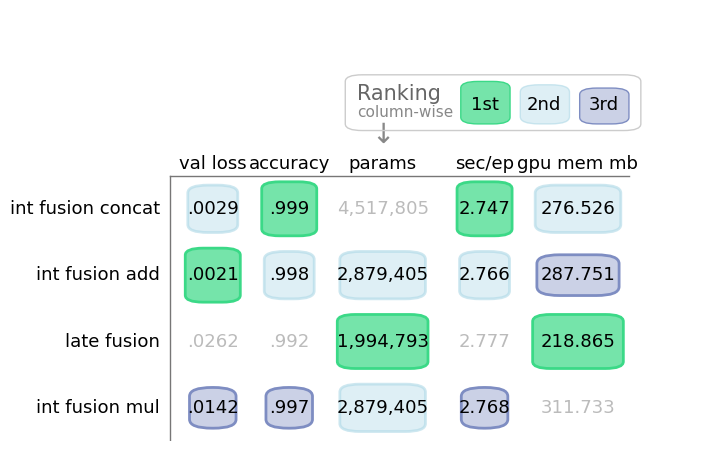

In [139]:
plot_table_task3_metrics(comparison_table, f"{RESULTS_DIR}/task3_metric_table.png")

### Results Analysis (Requirement 3.4)

The experimental results reveal a **clear performance gap between Intermediate and Late Fusion strategies**. All three intermediate variants achieved near-perfect validation accuracy (`>99.7%`) and substantially lower validation losses (`0.002–0.014`) compared to the Late Fusion baseline (`99.15%` accuracy, `0.026` loss). Notably, Intermediate Addition achieved the lowest validation loss (`0.0021`) with only `2.8M parameters`, while Intermediate Concatenation reached the highest accuracy (`99.91%`) at the cost of a larger model (`4.5M parameters`). Training logs show that intermediate strategies converge rapidly, often stabilizing within the first five epochs, whereas Late Fusion exhibits slower and more erratic learning. These results highlight the expected trade-off discussed at the start fo this section: Late Fusion simplifies feature combination, while Intermediate Fusion better exploits cross-modal correlations for improved performance

The superiority of intermediate fusion can be attributed to the spatially registered synthetic data. RGB and LiDAR modalities produce highly correlated features: for instance, a cube’s sharp vertex in the RGB image aligns with a depth discontinuity in the LiDAR data. Late Fusion’s higher validation loss suggests a potential "feature collapse," where the model over-relies on RGB features and compresses the LiDAR signal into a narrow embedding, limiting cross-modal alignment of geometrically meaningful features.

Among intermediate strategies, the choice depends on priorities:
- *Memory efficiency and generalization:* Intermediate Addition offers low validation loss, efficient parameter usage, and rapid, confident convergence.  
- *Maximum performance:* Intermediate Concatenation achieves the highest accuracy at the cost of increased parameters and complexity.

In summary, intermediate-level fusion is essential to preserve cross-modal spatial synergy for geometric classification. Element-wise addition provides the most efficient path to high-confidence convergence, while concatenation offers the richest representation with maximal accuracy.

> **Important Caveat.**  
> These conclusions apply only to the current setup. Data augmentations and regularization methods (e.g., dropout) were not used and could affect the relative performance of the variants. The same applies to Batch Normalization, which might improve Late Fusion and enhance generalization to real-world data. For classification tasks with noisy inputs, Late Fusion could potentially outperform Intermediate Fusion, particularly when it is not straightforward to determine the most meaningful layer at which to concatenate features.

> **Extra Observation.**  
> Previous experiments (available at the [handsoncv-fusion project link](https://wandb.ai/handsoncv-research/handsoncv-fusion?nw=nwuserguarinovanessaemanuela)) show that training the binary task with `CrossEntropyLoss()` and a 2D target caused instability in the Intermediate Multiplication strategy, highlighting the gradient sensitivity that can arise when optimizing over a loss surface defined by two competing logits.